<a href="https://colab.research.google.com/github/tylerscott3/CS290/blob/main/kmeansalgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [69]:
iris = load_iris()
df = pd.DataFrame( iris.data, columns = iris.feature_names)

In [70]:
data = load_iris()
X = data.data
y = data.target

In [71]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [72]:
df["species"] = iris.target

In [73]:
target_names = {
    0:'setosa',
    1:'versicolor',
    2:'virginica'
}

df['species_name'] = df['species'].map(target_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


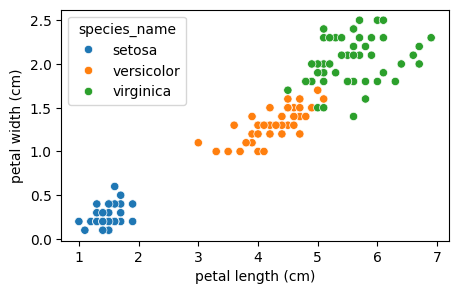

In [74]:
plt.figure(figsize=(5, 3))
sns.scatterplot( x = "petal length (cm)", y = "petal width (cm)", data = df, hue = "species_name");

In [75]:
centroids = df.groupby("species_name")[["petal length (cm)", "petal width (cm)"]].mean()

In [76]:
centroids

,petal length (cm),petal width (cm)
species_name,,
setosa,1.462,0.246
versicolor,4.260,1.326
virginica,5.552,2.026


In [77]:
centroids.loc["versicolor"]

,versicolor
petal length (cm),4.260
petal width (cm),1.326


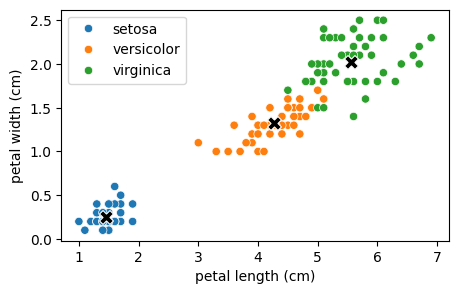

In [78]:
plt.figure(figsize=(5, 3))
sns.scatterplot( x = "petal length (cm)", y = "petal width (cm)", data = df, hue = "species_name")
sns.scatterplot( x = "petal length (cm)", y = "petal width (cm)", data = centroids, c = "black", marker="X", s = 100);

In [79]:
import numpy as np
while True:
    try:
        k = int(input("Enter the number of clusters (k): "))  # Prompt user to input k value
        if k <= 0:
            print("Error: The number of clusters must be a positive integer. Please try again.")
        else:
            break
    except ValueError:
        print("Error: Please enter a valid integer for the number of clusters.")

def initialize_centroids(X, k):
    # Get user input for the initialization method
    init_method = input("Enter the initialization method ('random' or 'manual'): ").strip().lower()

    if init_method == "random":
        # Randomly choose k data points as initial centroids
        indices = np.random.choice(X.shape[0], k, replace=False)
        centroids = X[indices]

    elif init_method == "manual":
        centroids = []
        print(f"Enter the coordinates for {k} centroids, each with 4 features (for Iris dataset).")

        for i in range(k):
            while True:
                # Ask the user to input the centroid's coordinates as a comma-separated string
                centroid_input = input(f"Enter coordinates for centroid {i + 1} (comma-separated): ")

                # Convert the input into a list of floats
                try:
                    centroid = list(map(float, centroid_input.split(',')))

                    # Check if the number of features matches (4 features for Iris)
                    if len(centroid) != 4:
                        print("Error: Each centroid must have exactly 4 features. Try again.")
                        continue

                    centroids.append(centroid)
                    break
                except ValueError:
                    print("Error: Invalid input. Please enter numeric values for the centroid coordinates.")

        centroids = np.array(centroids)
    else:
        print("Invalid initialization method. Defaulting to 'random'.")
        # Default to random initialization if invalid input is provided
        indices = np.random.choice(X.shape[0], k, replace=False)
        centroids = X[indices]

    return centroids


X = np.random.rand(10, 4)

centroids = initialize_centroids(X, k)
print("Initialized centroids:")
print(centroids)


Enter the number of clusters (k): 3
Enter the initialization method ('random' or 'manual'): random
Initialized centroids:
[[0.63116417 0.2114886  0.30718399 0.18431547]
 [0.65060443 0.28696133 0.49661907 0.80276952]
 [0.7111776  0.17377085 0.65881046 0.99199612]]


In [88]:
def kmeans_algorithm(X, k, init_method="random", tol = 1e-4):
    # Initialize centroids
    centroids = initialize_centroids(X, k, method=init_method)
    prev_centroids = np.zeros_like(centroids)

    # Store the iteration history for visualization
    history = []

    for i in range(10000):
        # Step 1: Assign each point to the nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Step 2: Recompute the centroids
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # Store history for visualization
        history.append((centroids.copy(), labels.copy()))

        # Check for convergence (if centroids don't change significantly)
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, labels, history

In [89]:
import numpy as np

def initialize_centroids(X, k, method="random"):

    if method == "random":
        # Randomly select k data points as initial centroids
        random_indices = np.random.choice(X.shape[0], k, replace=False)
        centroids = X[random_indices]
    # Add logic for other methods here, if needed.

    return centroids

In [90]:
def plot_kmeans_history(X, history, title="K-means Clustering"):
    plt.figure(figsize=(8, 6))
    for i, (centroids, labels) in enumerate(history):
        plt.cla()  # Clear axis before each iteration
        import matplotlib.pyplot as plt

# Create a new figure with a larger size
        plt.figure(figsize=(10, 8))  # Width = 10 inches, Height = 8 inches

# Your scatter plot code here
        plt.scatter(X[:, 1], X[:, 0], c=labels, cmap='viridis', s=50, alpha=0.5)
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red', s=200, linewidths=3)

# Display the plot
        plt.show()

        plt.title(f"{title} - Iteration {i + 1}")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.show()

In [99]:
def kmeans_algorithm(X, k, init_method="random", tol=1e-4):  # Add tol
    # Initialize centroids
    centroids = initialize_centroids(X, k, method=init_method)
    prev_centroids = np.zeros_like(centroids)

    # Store the iteration history for visualization
    history = []

    for i in range(10000):
        # Step 1: Assign each point to the nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Step 2: Recompute the centroids
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # Store history for visualization
        history.append((centroids.copy(), labels.copy()))

        # Check for convergence (if centroids don't change significantly)
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, labels, history # Make sure to return 3 values: centroids, labels, and history

In [100]:
def calculate_inertia(X, centroids, labels):
    # Calculate the squared Euclidean distance between each point and its assigned centroid
    inertia = 0
    for i in range(len(X)):
        inertia += np.linalg.norm(X[i] - centroids[labels[i]]) ** 2
    return inertia



In [101]:
def initialize_centroids_kmeans_plus_plus(X, k):
    # Choose the first centroid randomly
    centroids = [X[np.random.randint(0, X.shape[0])]]

    for _ in range(1, k):
        # Calculate the distance between each point and the closest centroid
        distances = np.min([np.linalg.norm(X - centroid, axis=1) ** 2 for centroid in centroids], axis=0)
        # Select the next centroid based on the squared distance distribution
        prob_dist = distances / np.sum(distances)
        next_centroid_idx = np.random.choice(range(X.shape[0]), p=prob_dist)
        centroids.append(X[next_centroid_idx])

    return np.array(centroids)

In [102]:
from sklearn.metrics import silhouette_score

def calculate_silhouette_score(X, labels):
    return silhouette_score(X, labels)

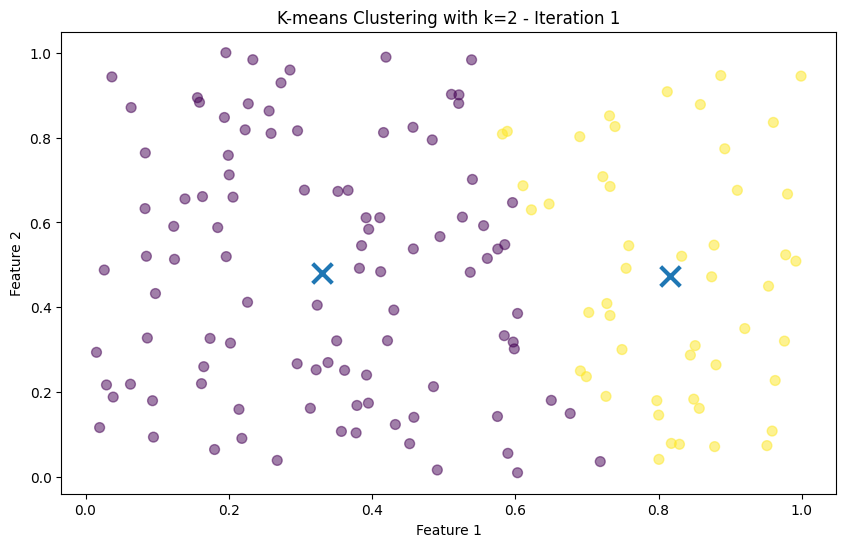

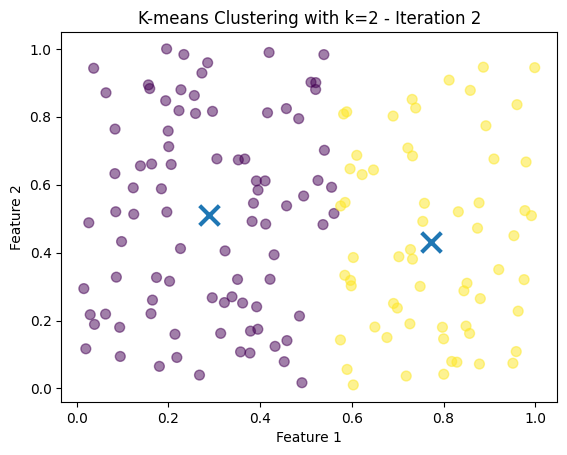

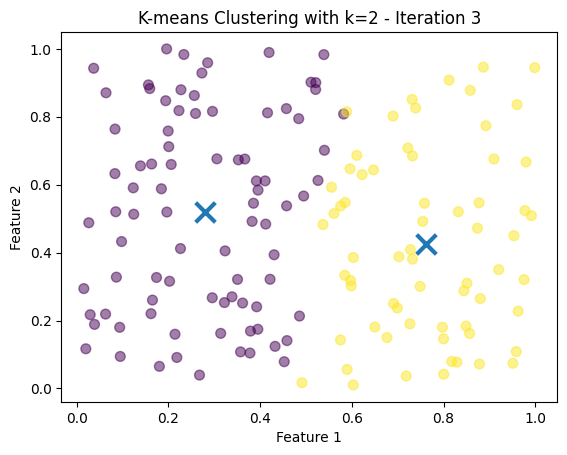

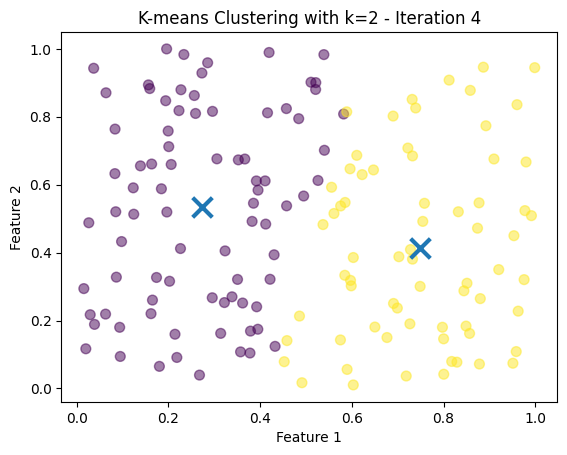

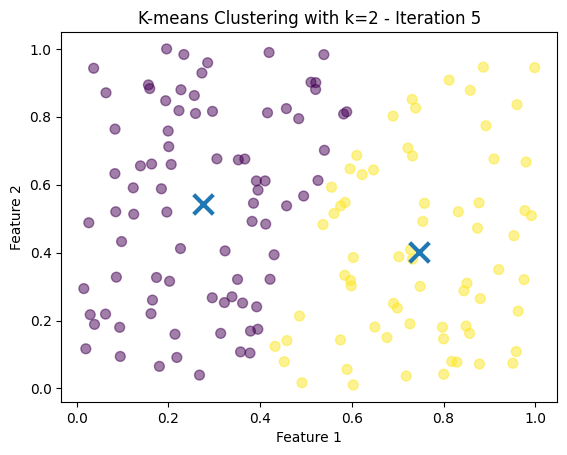

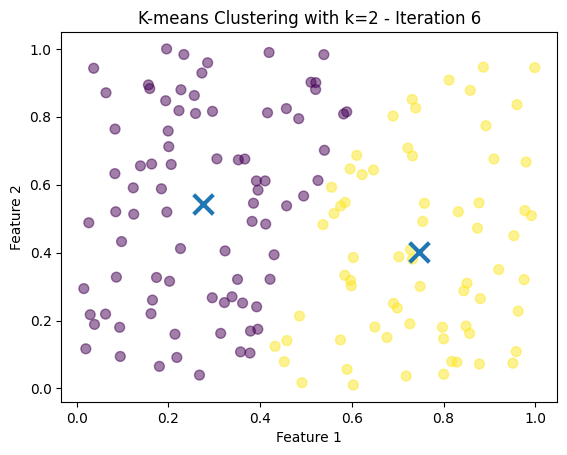

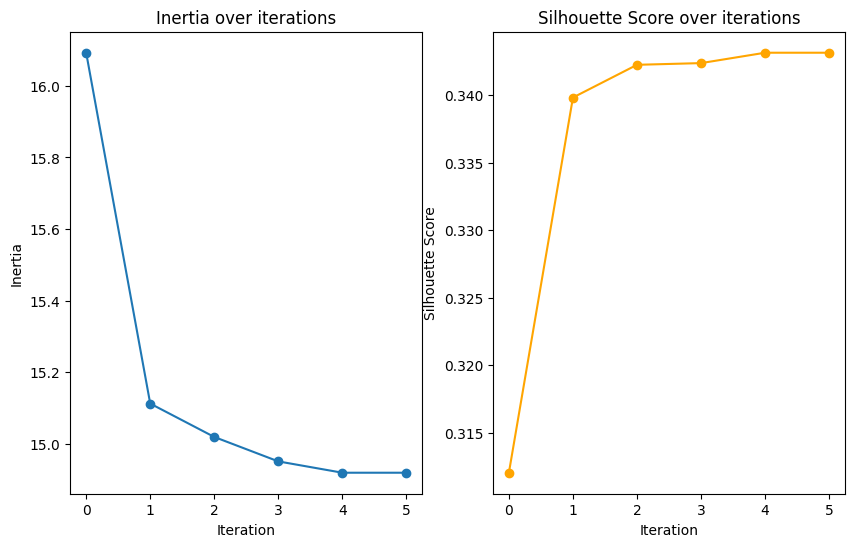

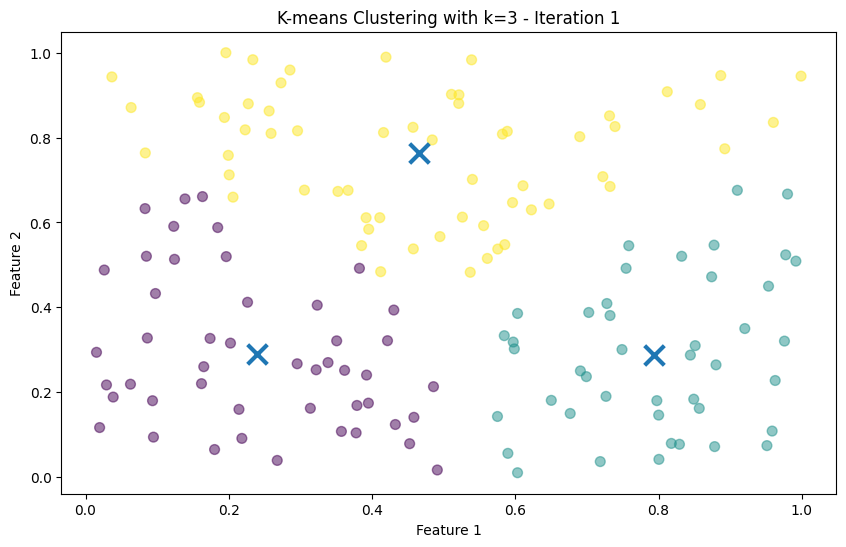

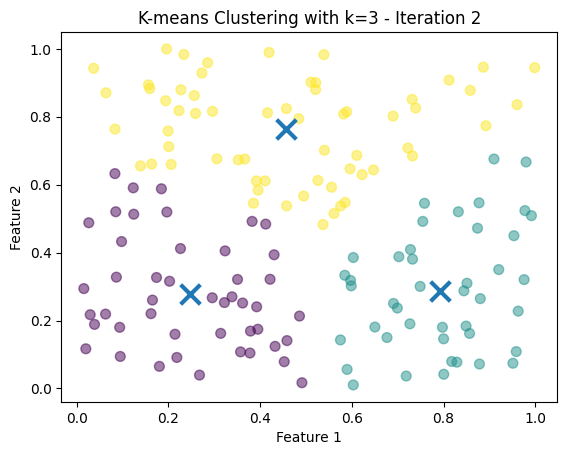

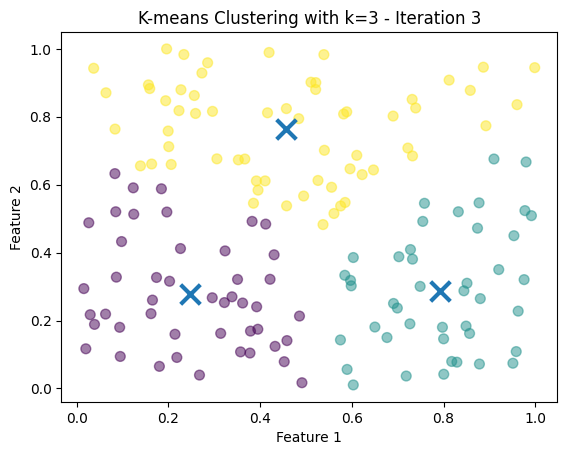

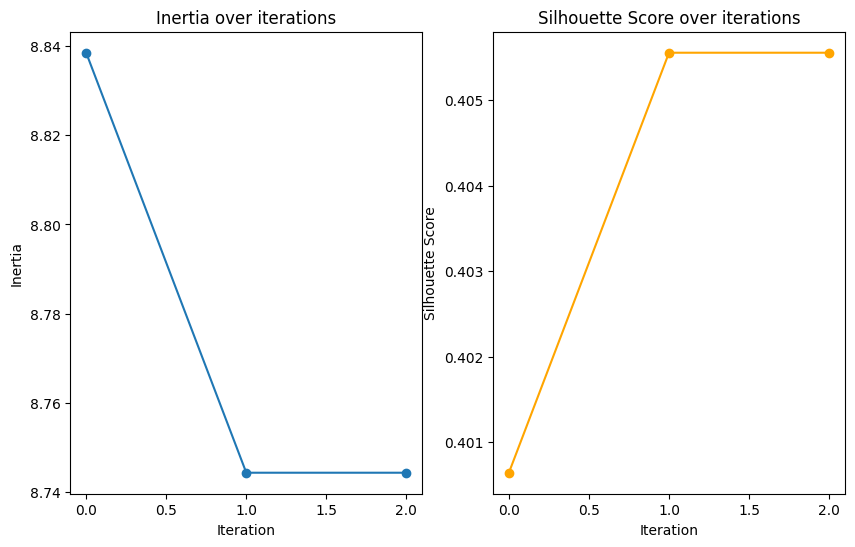

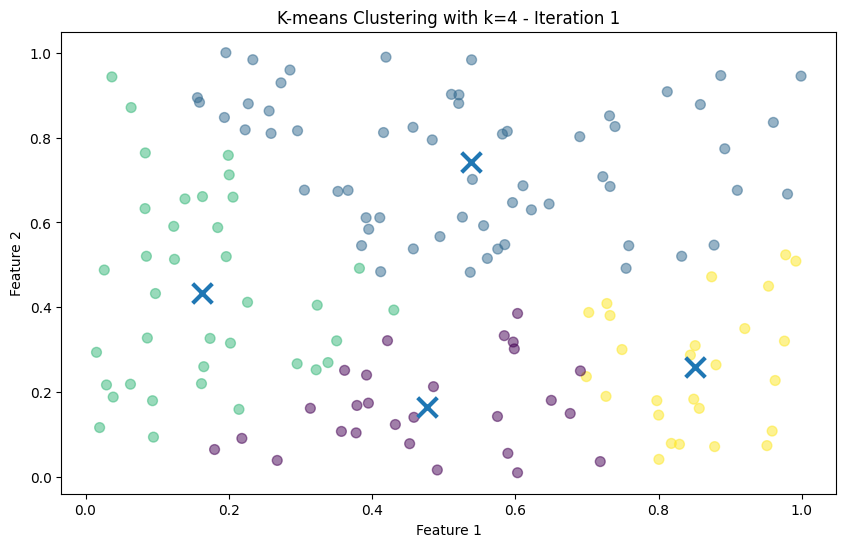

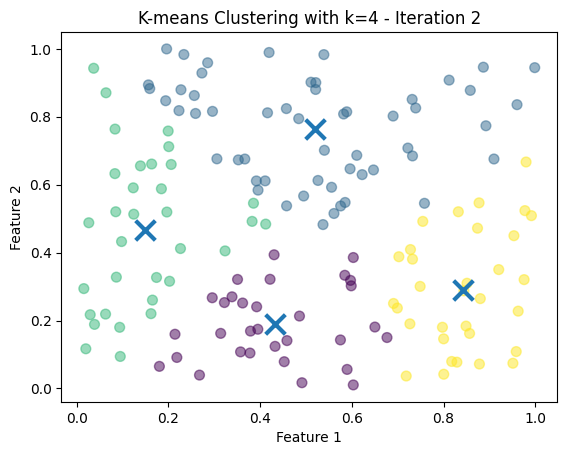

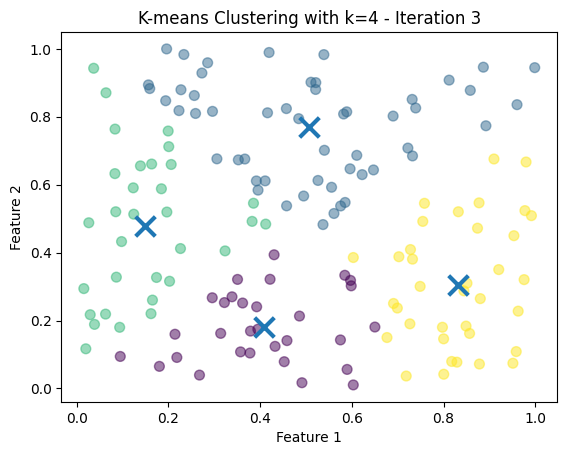

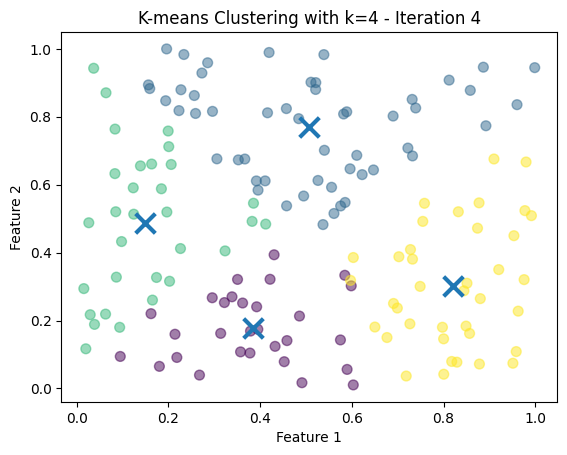

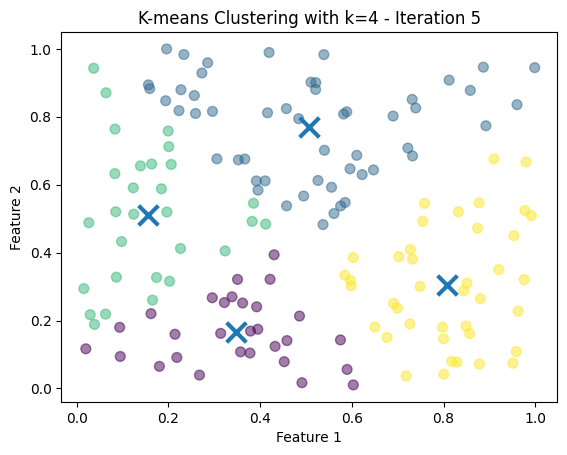

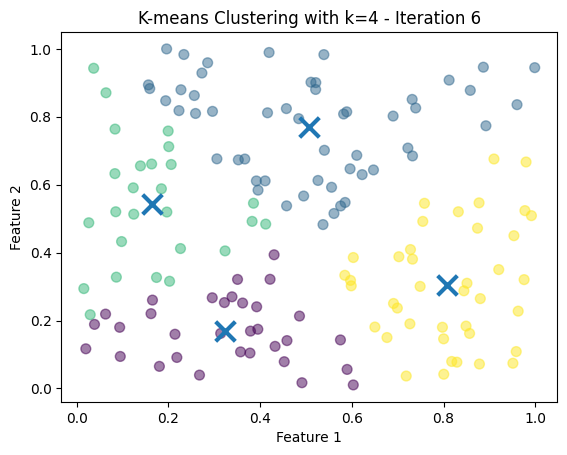

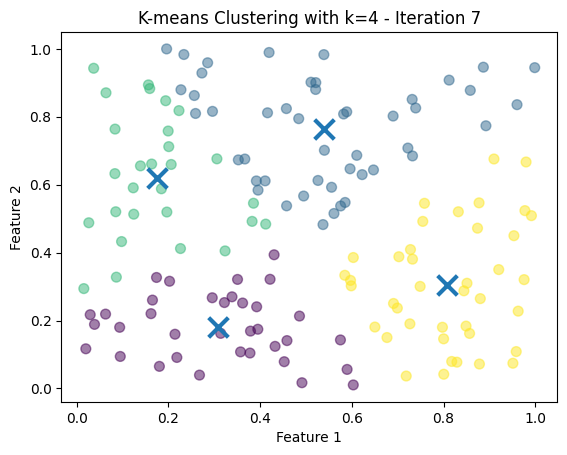

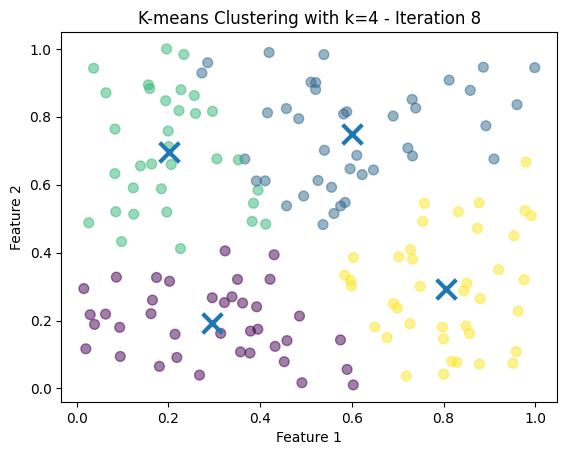

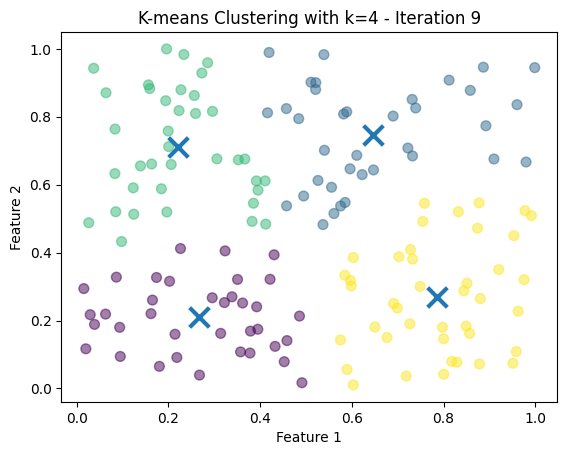

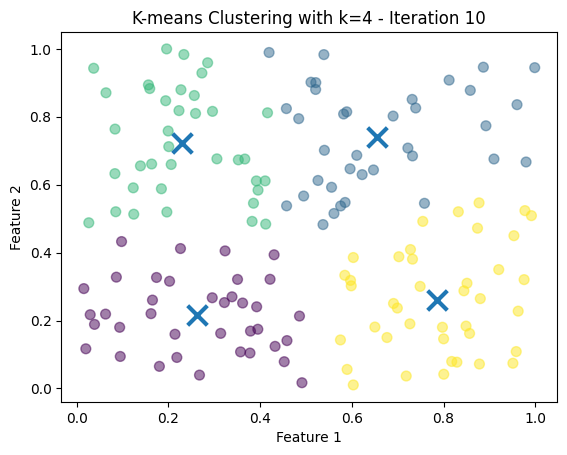

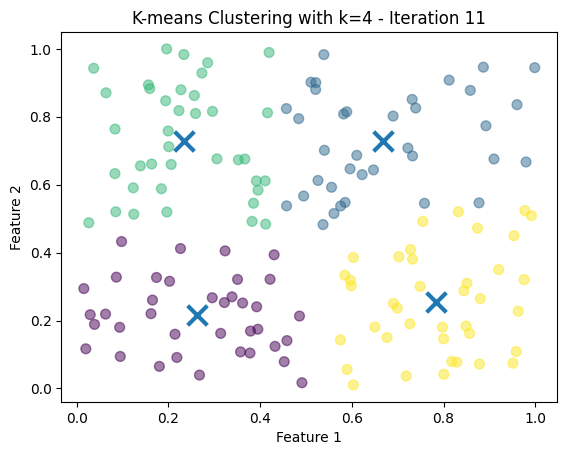

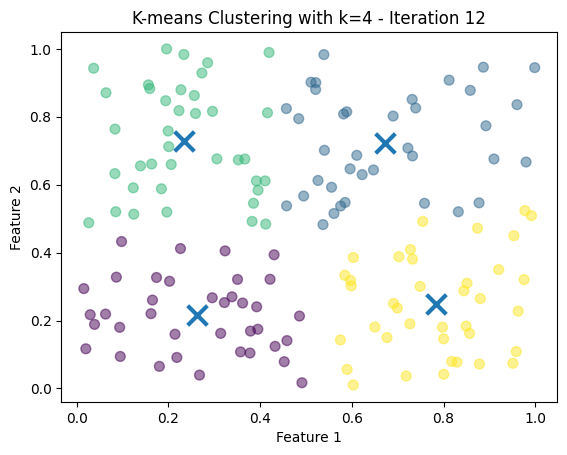

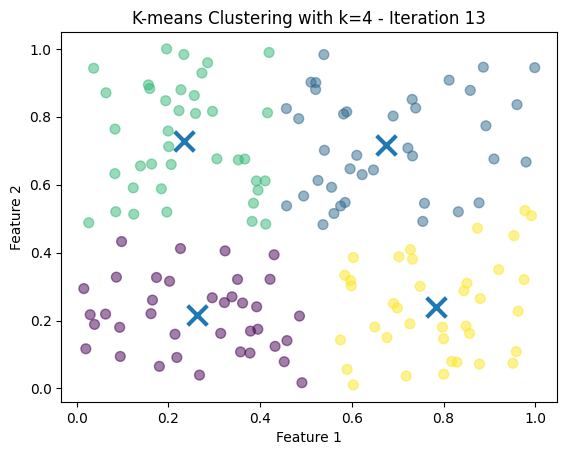

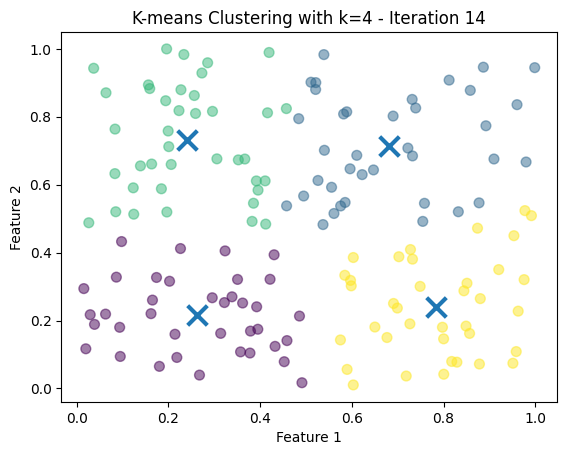

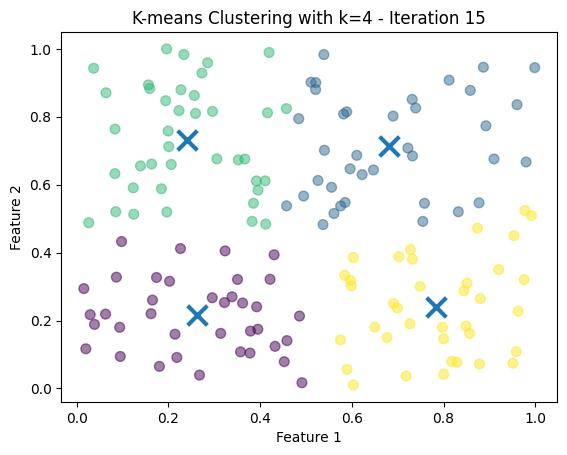

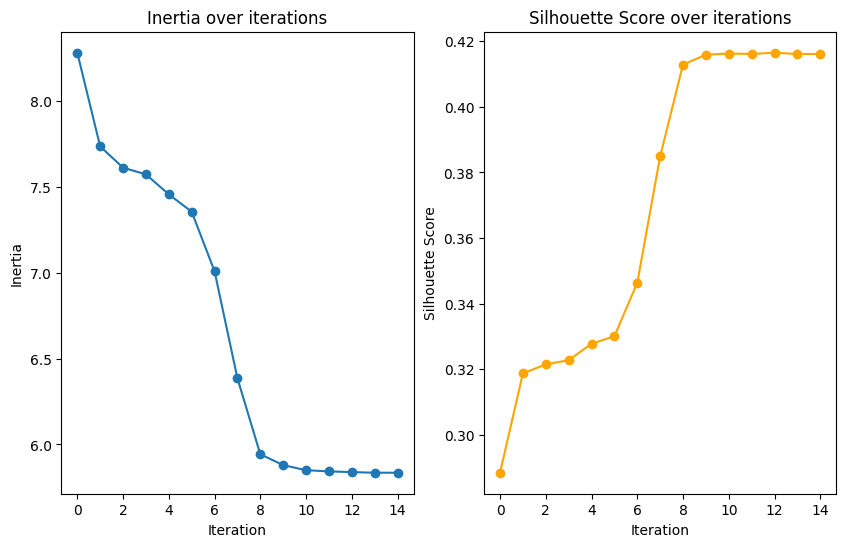

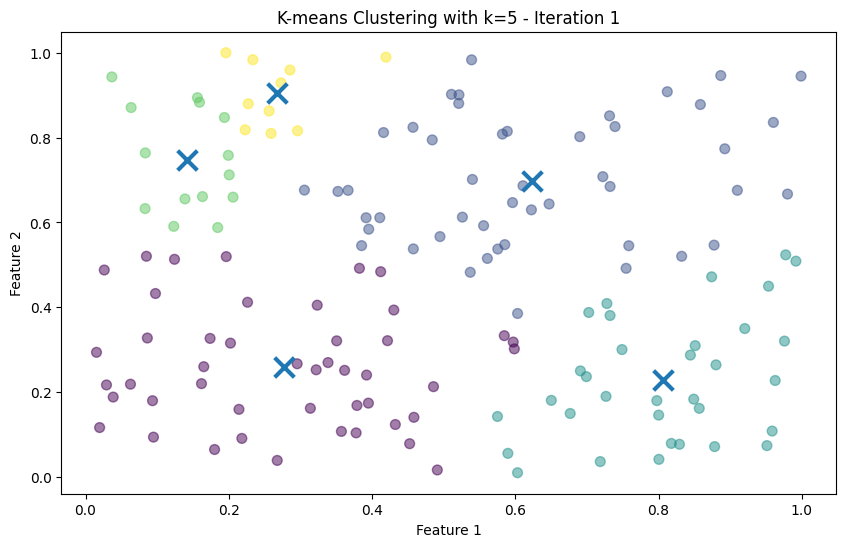

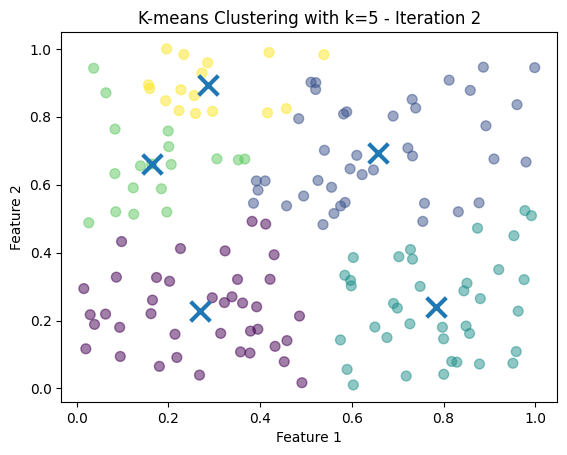

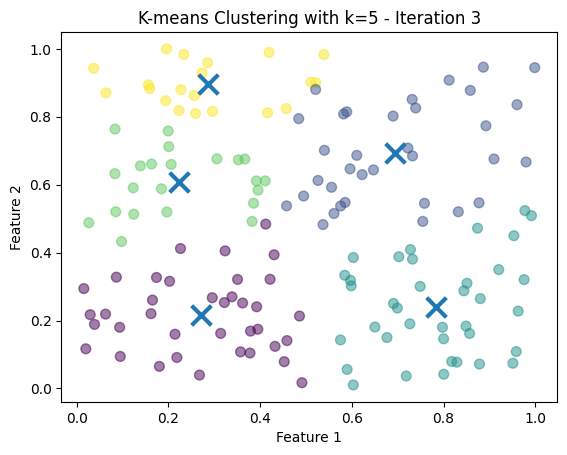

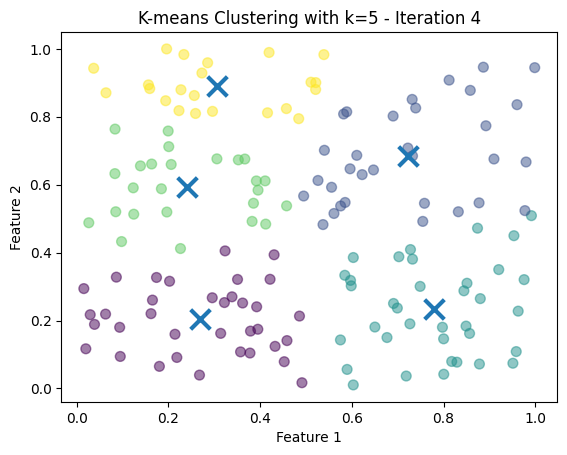

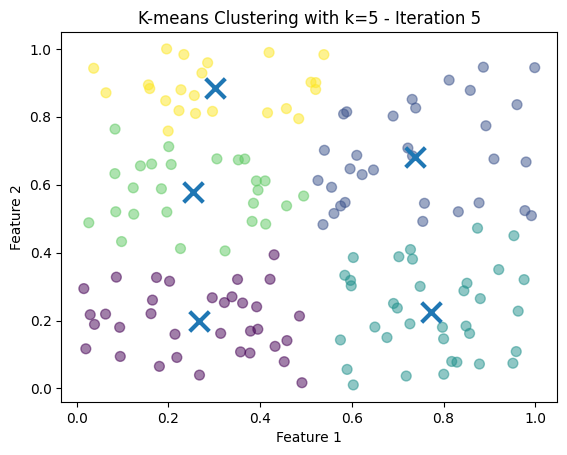

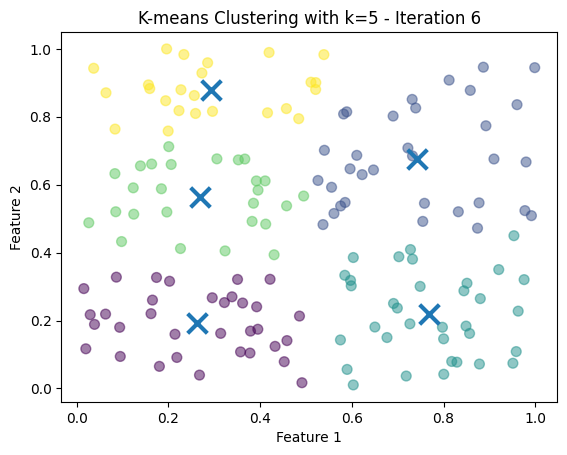

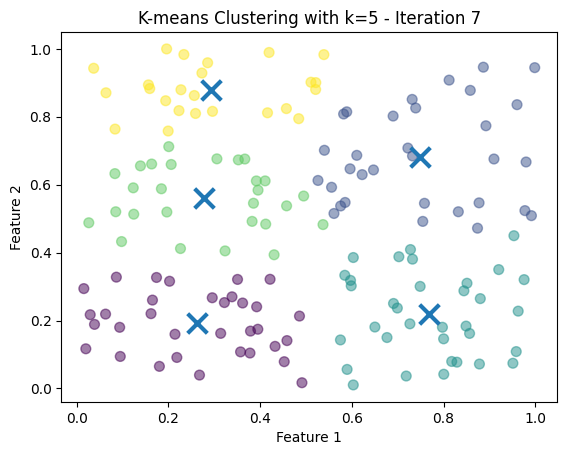

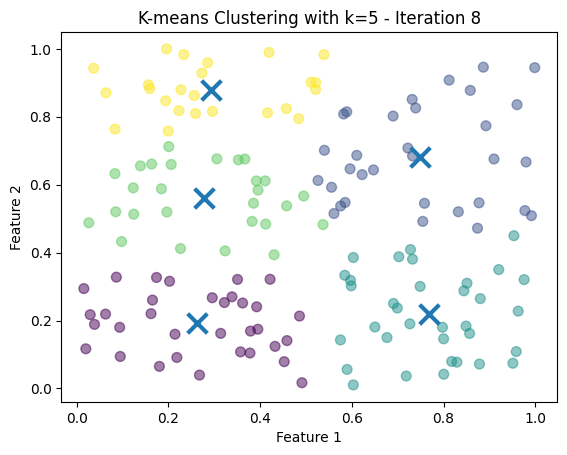

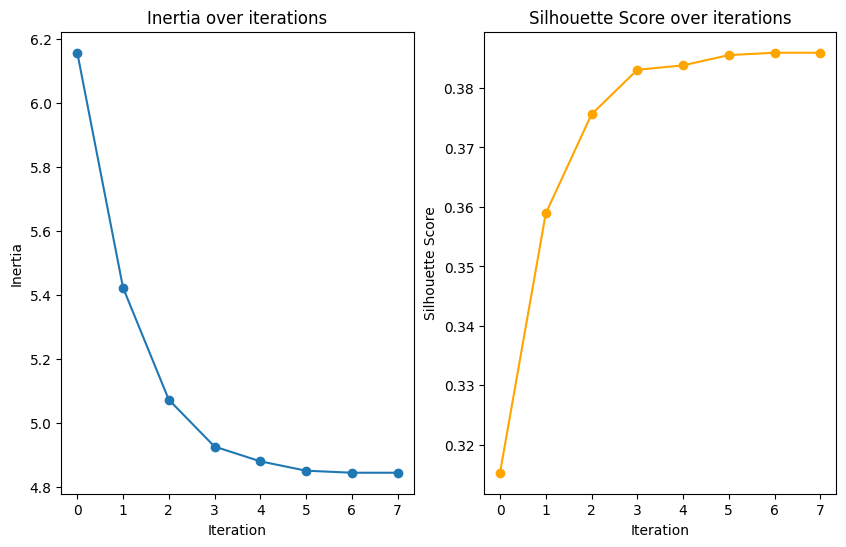

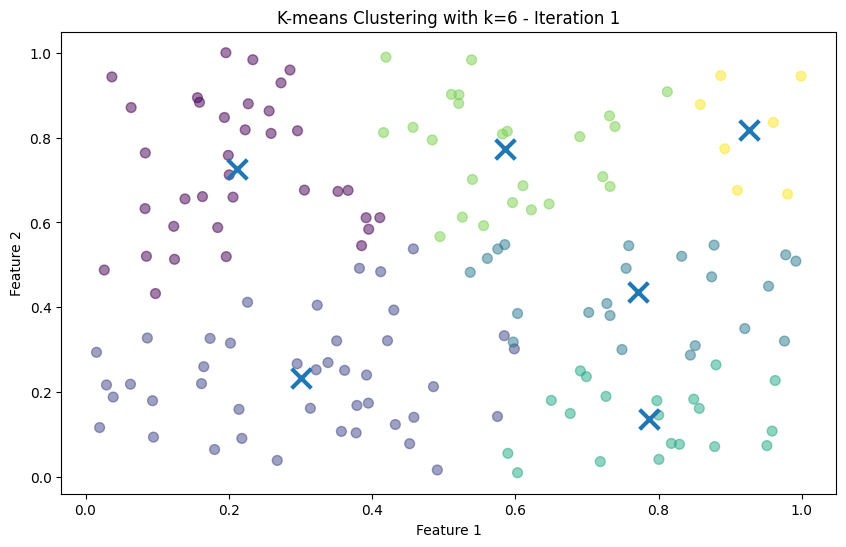

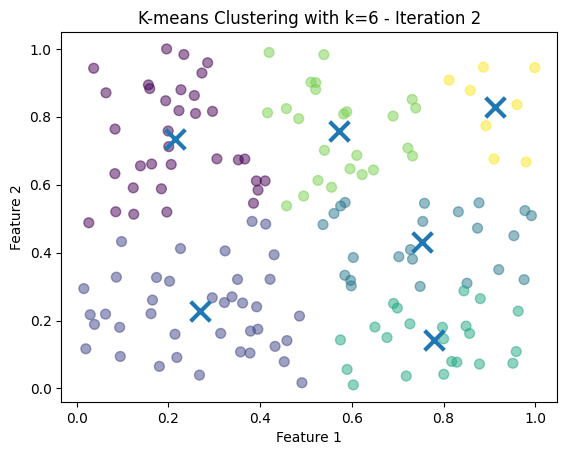

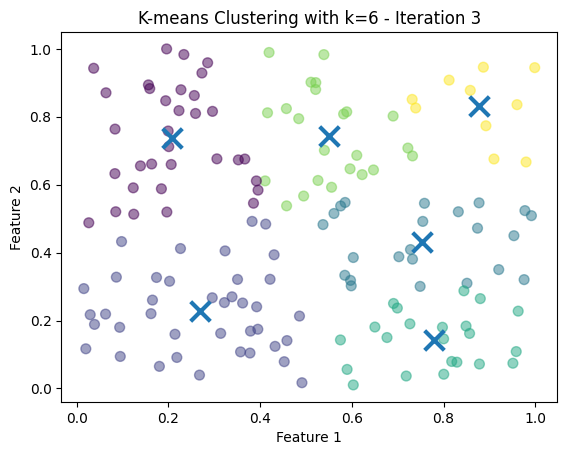

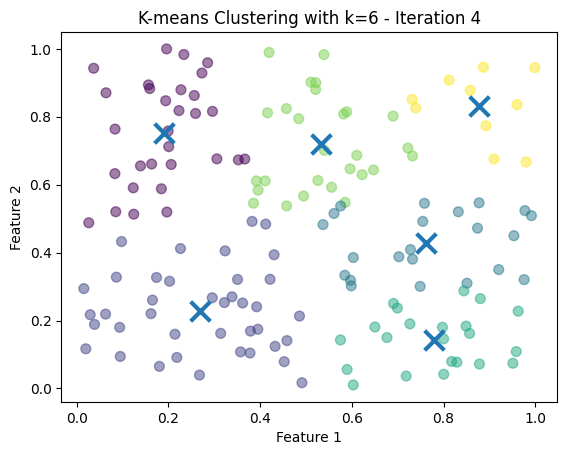

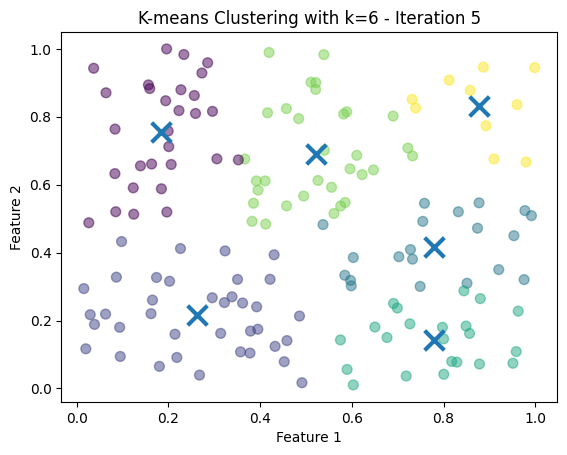

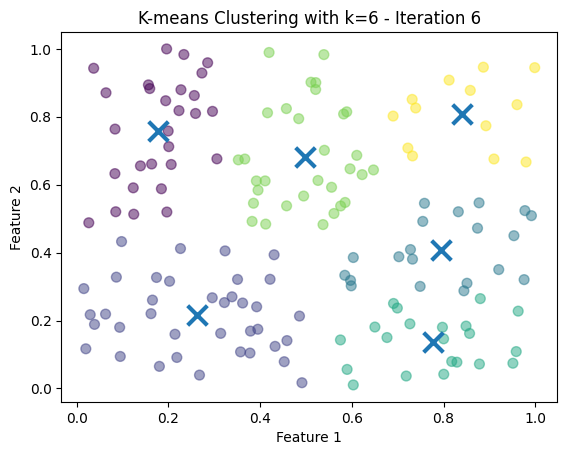

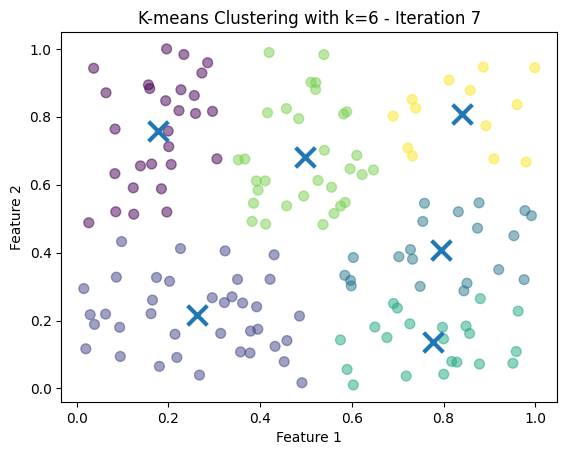

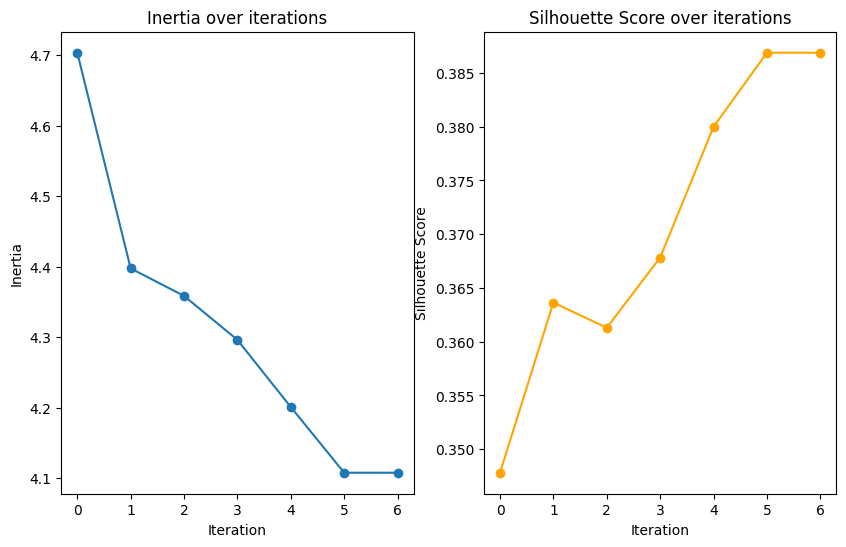

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

def initialize_centroids_kmeans_plus_plus(X, k):
    centroids = [X[np.random.randint(0, X.shape[0])]]
    for _ in range(1, k):
        distances = np.min([np.linalg.norm(X - centroid, axis=1) ** 2 for centroid in centroids], axis=0)
        prob_dist = distances / np.sum(distances)
        next_centroid_idx = np.random.choice(range(X.shape[0]), p=prob_dist)
        centroids.append(X[next_centroid_idx])
    return np.array(centroids)

def calculate_inertia(X, centroids, labels):
    inertia = 0
    for i in range(len(X)):
        inertia += np.linalg.norm(X[i] - centroids[labels[i]]) ** 2
    return inertia

def kmeans_algorithm(X, k, init_method="random", max_iters=100, tol=1e-4):
    # Initialize centroids
    if init_method == "random":
        centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    elif init_method == "kmeans++":
        centroids = initialize_centroids_kmeans_plus_plus(X, k)
    else:
        raise ValueError("Invalid initialization method.")

    prev_centroids = np.zeros_like(centroids)
    history = []
    inertia_history = []
    silhouette_history = []

    for i in range(max_iters):
        # Step 1: Assign each point to the nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Step 2: Recompute the centroids
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # Calculate inertia
        inertia = calculate_inertia(X, new_centroids, labels)

        # Calculate silhouette score
        silhouette_avg = calculate_silhouette_score(X, labels)

        inertia_history.append(inertia)
        silhouette_history.append(silhouette_avg)

        # Store history for visualization
        history.append((new_centroids.copy(), labels.copy()))

        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, labels, history, inertia_history, silhouette_history

def plot_kmeans_history(X, history, inertia_history, silhouette_history, title="K-means Clustering"):
    plt.figure(figsize=(10, 6))
    for i, (centroids, labels) in enumerate(history):
        plt.cla()  # Clear axis before each iteration
        plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='x',  s=200, linewidths=3)
        plt.title(f"{title} - Iteration {i + 1}")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.show()

    # Plot inertia and silhouette score
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    ax1.plot(inertia_history, marker='o')
    ax1.set_title("Inertia over iterations")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Inertia")

    ax2.plot(silhouette_history, marker='o', color='orange')
    ax2.set_title("Silhouette Score over iterations")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Silhouette Score")

    plt.show()

# Example usage
#X = np.random.rand(150, 2)  # Example data, replace with the actual dataset like Iris or Penguins
k_values = [2, 3, 4, 5, 6]

for k in k_values:
  centroids, labels, history, inertia_history, silhouette_history = kmeans_algorithm(X, k, init_method="kmeans++")
  plot_kmeans_history(X, history, inertia_history, silhouette_history, title=f"K-means Clustering with k={k}")
